# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
Признаки
DateCrawled — дата скачивания анкеты из базы\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
Repaired — была машина в ремонте или нет\
DateCreated — дата создания анкеты\
NumberOfPictures — количество фотографий автомобиля\
PostalCode — почтовый индекс владельца анкеты (пользователя)\
LastSeen — дата последней активности пользователя\

Целевой признак\
Price — цена (евро)

# План проекта:

Загрузим и изучим данные. Заполним пропущенные значения и обработам аномалии в столбцах. \
Удалим неинформативные признаки.\
Подготовим выборки для обучения моделей.\
Обучим разные модели: линейную регрессию, SGD - регрессию, библиотеки градиентного бустинга CatBoost и LightGBM. Для каждой модели попробуем разные гиперпараметры.\
Проанализируем время обучения, время предсказания и качество моделей.\
Выберем лучшую модель, проверим её качество на тестовой выборке.

Заказчику важны:

1. качество предсказания;
2. скорость предсказания;
3. время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import time 

from numpy.random import RandomState
state = np.random.RandomState(12345)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
print('Количество стобцов:', data.shape[1])
print('Количество строк:', data.shape[0])
display(data.head())
data.info()

Количество стобцов: 16
Количество строк: 354369


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# Создадим функции для отрисовки графиков
def function_digital(data, columns):
    plt.figure(figsize=(20,10), dpi= 80)
    sns.kdeplot(data[columns], label=columns, shade=True, color="y", alpha=1)
    plt.title(columns, fontsize=22)
    plt.legend()
    plt.show()


In [7]:
dig_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

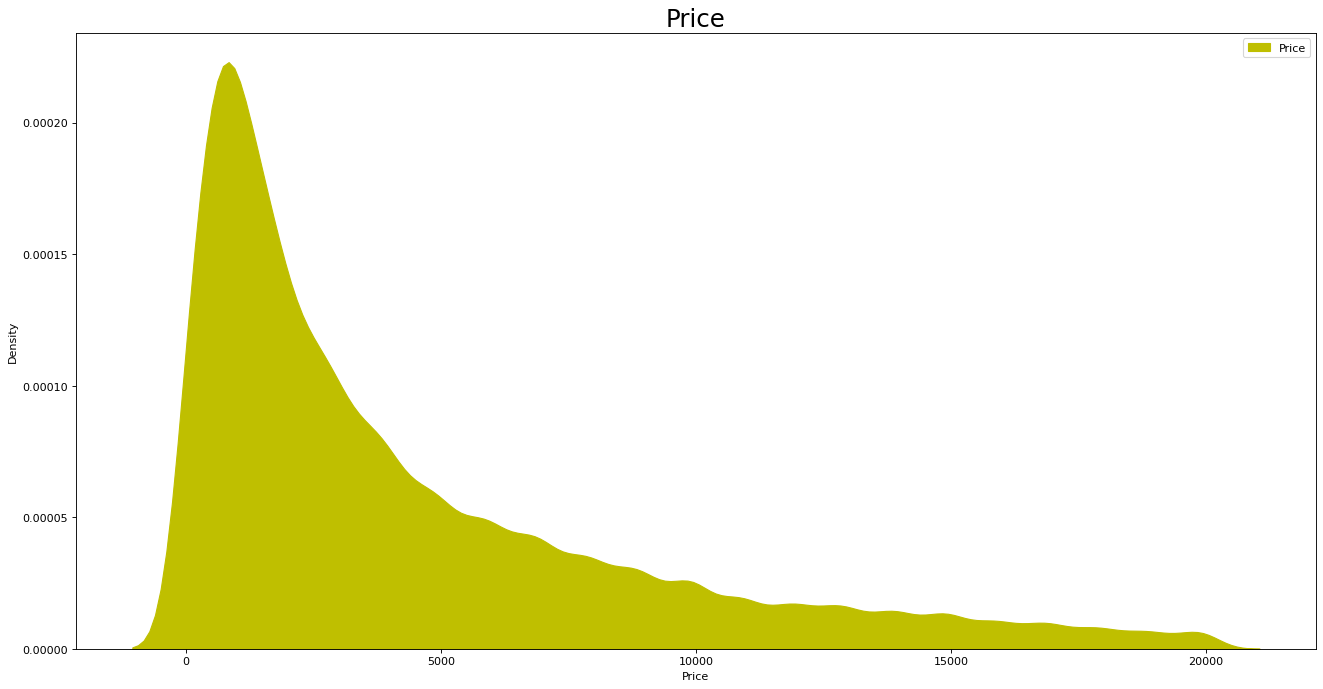

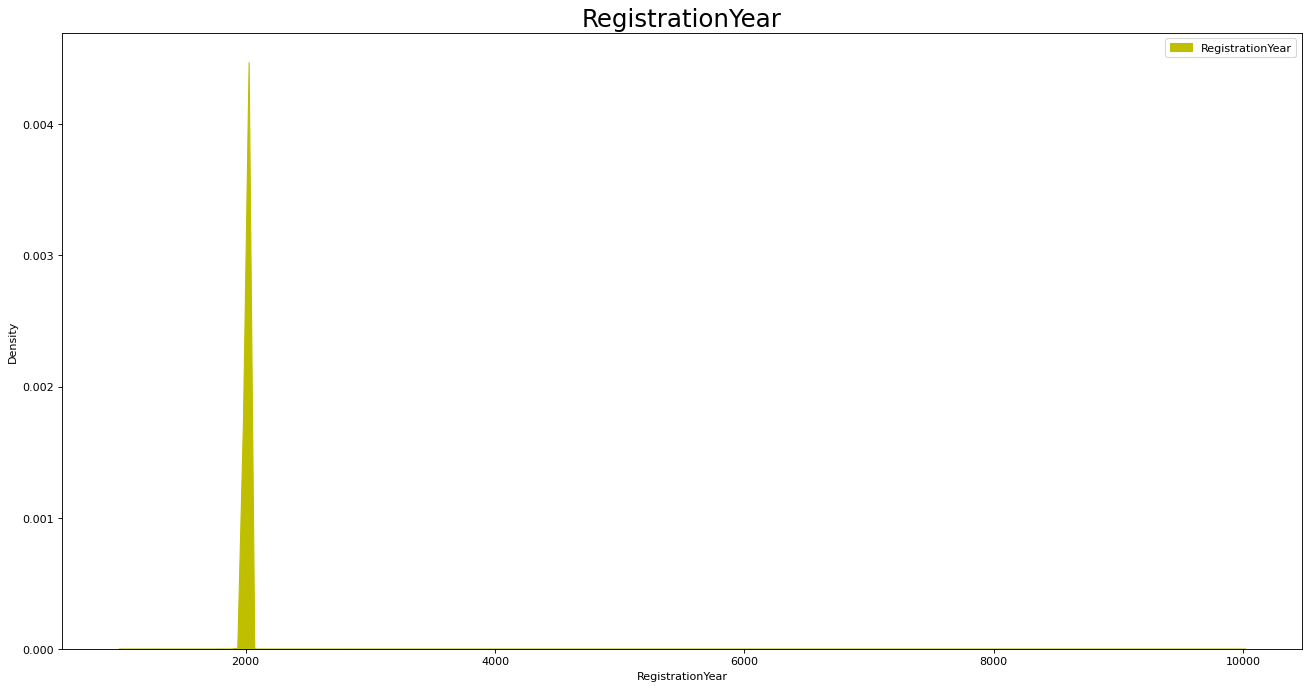

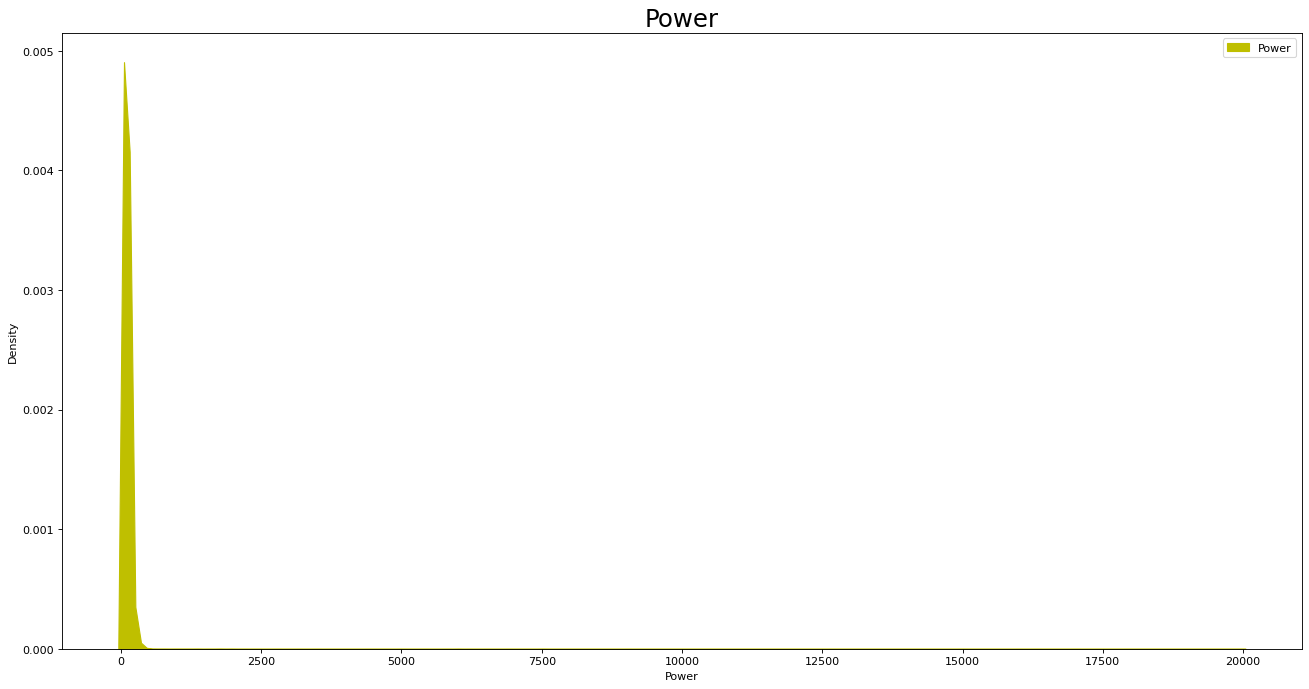

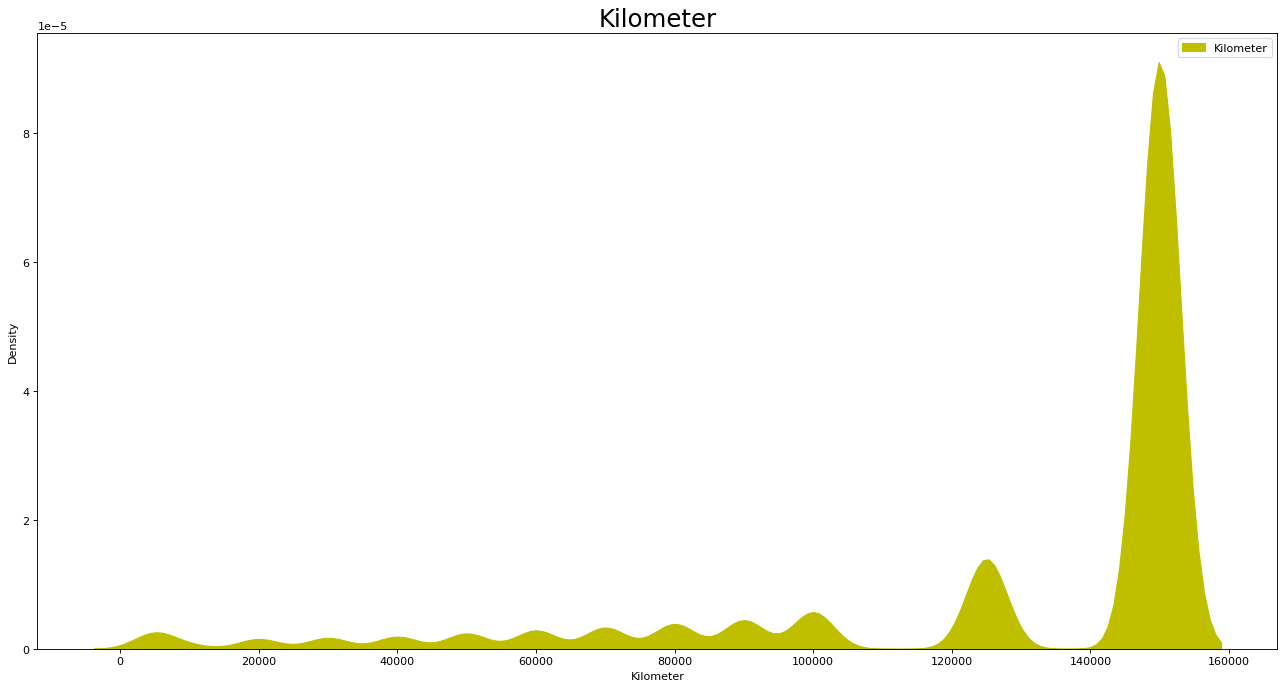

In [8]:
for i in dig_features:
    function_digital(data, i)

In [9]:
# Проверим на наличие дупликатов
data.duplicated().sum()

4

In [10]:
# Удалим дубликаты
data = data.drop_duplicates()
data.duplicated().sum()

0

In [11]:
# Столбцы 'DateCrawled','NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen' 
# не влияют на стоимость автомобиля, поэтому их удалим
data = data.drop(['DateCrawled','NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen'], axis = 1)

In [12]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [13]:
# Переименуем столбцы в соответствии с РЕР 8
data = data.rename(columns = {'VehicleType':'vehicle_type',
                              'RegistrationYear':'registration_year', 
                              'Gearbox' : 'gear_box',
                              'RegistrationMonth':'registration_month', 
                              'FuelType':'fuel_type', 
                              'Repaired':'repaired'
                             })

In [14]:
# Переведем все названия столбцов в нижный регистр
data.columns = data.columns.str.lower()

In [15]:
# Проверим целевой признак
data['price'].value_counts()

price
0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: count, Length: 3731, dtype: int64

В данных имеется 10772 записи с ценой, равной 0. Информативность данного признака отсутствует. Удалим эти строки. Кроме того, стоимость автомобиля в 200 евро - это стоимость автомобиля на запчасти, т.е. для наших целей также не подходит. Удалим строки.

In [16]:
data = data.query('price >= 200')
data['price'].describe()

count    336903.000000
mean       4643.642063
std        4515.355328
min         200.000000
25%        1250.000000
50%        2950.000000
75%        6650.000000
max       20000.000000
Name: price, dtype: float64

In [17]:
# Найдем количество пропусков
data.isna().sum()

price                     0
vehicle_type          31380
registration_year         0
gear_box              15555
power                     0
model                 16574
kilometer                 0
registration_month        0
fuel_type             27214
brand                     0
repaired              62445
dtype: int64

In [18]:
# Найдем долю пропусков в столбцах, содержащих пропуски
print('Доля пропусков в vehicle_type: {:.2%}'.format(data['vehicle_type'].isna().mean()))
print()
print('Доля пропусков в gear_box: {:.2%}'.format(data['gear_box'].isna().mean()))
print()
print('Доля пропусков в model: {:.2%}'.format(data['model'].isna().mean()))
print()
print('Доля пропусков в fuel_type: {:.2%}'.format(data['fuel_type'].isna().mean()))
print()
print('Доля пропусков в repaired: {:.2%}'.format(data['repaired'].isna().mean()))

Доля пропусков в vehicle_type: 9.31%

Доля пропусков в gear_box: 4.62%

Доля пропусков в model: 4.92%

Доля пропусков в fuel_type: 8.08%

Доля пропусков в repaired: 18.54%


Доля пропусков существенна, просто удалить пропуски считаю нецелесообразным. Попробуем заполнить пропуски другими способами.
1. vehicle_type. Заменим пропуски на тип 'other'. 
2. gearbox. Пропуски в этом столбце связаны с тем, что пользователи по умолчанию считают коробку передач механической, а автоматическую указывают как существенную опцию. Кроме того, учтем год выборки - 2016. Заменим пропуски типом 'manual' . 
3. model. Заменим пропуски на тип 'other'.
4. FuelType. Переименуем petrol в gasoline, поскольку оба означают "бензин". Заменим пропуски на тип 'other'.
5. Repaired. Пропуски в этом столбце связаны с тем, что пользователи по умолчанию считают автомобиль не бывшим в ремонте, а факты ремонта указывают специально.Для всех NaN установим значение 'no'.

In [19]:
# Найдем уникальные значения в столбце "тип кузова"
data.vehicle_type.value_counts()

vehicle_type
sedan          88574
small          75625
wagon          63130
bus            28213
convertible    19778
coupe          15444
suv            11754
other           3005
Name: count, dtype: int64

In [20]:
# В связи с тем, что определить тип кузова расчетным методом не удастся, заменяем пропуски на тип 'other'
data.vehicle_type.fillna('other', inplace=True)

In [21]:
# Найдем уникальные значения стобца "коробка передач"
data.gear_box.value_counts()

gear_box
manual    256860
auto       64488
Name: count, dtype: int64

In [22]:
# Заменим пропуски типом 'manual'    
data.gear_box.fillna('manual', inplace=True)

In [23]:
# Найдем уникальные значения стобца "модель"
data.model.value_counts()

model
golf                  27755
other                 23241
3er                   19013
polo                  12120
corsa                 11546
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: count, Length: 250, dtype: int64

In [24]:
# Заменяем пропуски на тип 'other'
data.model.fillna('other', inplace=True)

In [25]:
# Найдем уникальные значения стобца "тип топлива"
data.fuel_type.value_counts()

fuel_type
petrol      206709
gasoline     96829
lpg           5146
cng            548
hybrid         225
other          147
electric        85
Name: count, dtype: int64

In [26]:
# Переименуем petrol в gasoline, поскольку оба означают "бензин"
data['fuel_type'] = data['fuel_type'].replace(['petrol'],'gasoline')

In [27]:
# Заменяем пропуски на тип 'other'
data.fuel_type.fillna('other', inplace=True)

In [28]:
# Найдем уникальные значения стобца "repaired"
data.repaired.value_counts()

repaired
no     242458
yes     32000
Name: count, dtype: int64

In [29]:
# Заменим пропуски на 'no'
data.repaired.fillna('no', inplace=True)

In [30]:
# Посмотрим, что у нас получилось
data.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gear_box              0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

Пропуски обработаны, необходимо обработать аномалии.

In [31]:
# найдем уникальные значения в столбце "год регистрации"
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 2066, 1949,
       2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300, 9000, 2900,
       6000, 5900, 1000, 5911, 1400, 5000, 4000, 1948, 1952, 8500, 1932,
       1950, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 3000, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       1600, 1111, 1039, 2800, 1931, 4500, 1602, 7800, 1947, 1927, 7100,
       1300, 8200, 1946], dtype=int64)

Считается, что первенство в выдаче регистрационных номеров принадлежит Мюнхену. 
Там таблички с номерами начали устанавливать на машины в 1899 году. 
Эстафету подхватили в крупных городах других стран: 
Париж (1900 год), Нью-Иорк (1901 год), Лондон (1903 год).
В дореволюционной России решение о необходимости регистрации автомобилей принимали городские власти. 
25 июня 1900 года Городской Думой Санкт-Петербурга было принято постановление 
«О порядке пассажирского и грузового движения по городу Санкт-Петербургу на автомобилях».
В числе прочих регламентирующих положений наличествовал пункт, 
вводящий обязательное медицинское освидетельствование водителей, 
ежегодный технический осмотр автомобилей и их обязательную регистрацию с выдачей номерных знаков — «жестянок». 
Однако ввиду малочисленности машин и «экзотичности» закона нововведение в Санкт-Петербурге не прижилось. 
Всерьез практику обязательного крепления к авто регистрационного номера 
первыми в Российской империи освоили рижане в 1904 году.
Ограничим дату регистрации автомобилей 1904 годом, остальные данные точно аномалии.
Поскольку наши данные на 2016 год, удалим все строки с годом после 2016.

In [32]:
# Вообще правильнее было бы изменить года выпуска автомобилей на медианное по каждой модели, 
# ведь модели выпускались в определенное время. Но где взять такие данные, я не придумал

In [33]:
data = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1904)]

In [34]:
# Найдем уникальные значения в столбце "мощность"
data.power.value_counts()

power
0       30214
75      21636
60      14164
150     13669
101     12335
        ...  
6018        1
612         1
1596        1
1506        1
1241        1
Name: count, Length: 679, dtype: int64

In [35]:
data_sort_power = data[['price', 'registration_year', 'model']][data['power'] == 0].sort_values(['price', 'model'])
data_sort_power

,price,registration_year,model
316924,200,1960,145
22472,200,1995,1_reihe
63101,200,1996,1_reihe
206816,200,1997,1_reihe
262831,200,1999,2_reihe
...,...,...,...
107020,20000,2005,transporter
247893,20000,2009,transporter
319914,20000,2009,transporter
120344,20000,2006,tt


Существенное количество записей с мощностью равной нулю может объясняться тем, что автомобиль может быть либо без двигателя, либо с неисправным, требующим ремонта двигателем. Однако выборка эту теорию не подтверждает. 

Автомобили мощностью более 800 лошадиных сил выпуском до 2016 года в природе не встречаются. В наших данных это ошибка пользователей, которые спутали мощность двигателя и другие параметры (к примеру, объем двигателя). Заменим значения мощностей меньше 50 л.с. и больше 350 л.с. медианой по каждой модели отдельно

In [36]:
for model_auto in data['model'].unique():
    data.loc[(data['power'] < 50) | (data['power'] > 350), 'power'] = data['power'].median()

In [37]:
data.power.value_counts()

power
105    46194
75     21636
60     14164
150    13669
101    12335
       ...  
248        1
339        1
331        1
323        1
282        1
Name: count, Length: 294, dtype: int64

In [38]:
# Проверим уникальные значения месяца регистрации
data.registration_month.value_counts()

registration_month
3     32245
6     29407
4     27268
5     27192
0     26779
7     25488
10    24554
11    22761
12    22650
9     22419
1     21528
8     21106
2     19851
Name: count, dtype: int64

In [39]:
# Имеем ошибки в месяце - месяц с номером 101 и номером 0 не существует. Заменим ошибочные данные медианой
data.loc[(data['registration_month'] == 101) | (data['registration_month'] == 0), 'registration_month'] = data['registration_month'].median()
data.registration_month.value_counts()

registration_month
6     56186
3     32245
4     27268
5     27192
7     25488
10    24554
11    22761
12    22650
9     22419
1     21528
8     21106
2     19851
Name: count, dtype: int64

In [40]:
# Для корректной работы моделей приведем числовые значения к единому типу
data[['power', 'registration_month']] = data[[
    'power', 'registration_month']].astype('int')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323248 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               323248 non-null  int64 
 1   vehicle_type        323248 non-null  object
 2   registration_year   323248 non-null  int64 
 3   gear_box            323248 non-null  object
 4   power               323248 non-null  int32 
 5   model               323248 non-null  object
 6   kilometer           323248 non-null  int64 
 7   registration_month  323248 non-null  int32 
 8   fuel_type           323248 non-null  object
 9   brand               323248 non-null  object
 10  repaired            323248 non-null  object
dtypes: int32(2), int64(3), object(6)
memory usage: 27.1+ MB


In [42]:
data.reset_index(drop= True , inplace= True )

Еще раз построим графики для очищенных данных

In [43]:
cat_features = ['vehicle_type', 'model', 'gear_box', 'fuel_type', 'brand', 'repaired']
dig_features = ['price', 'registration_year', 'power', 'kilometer']

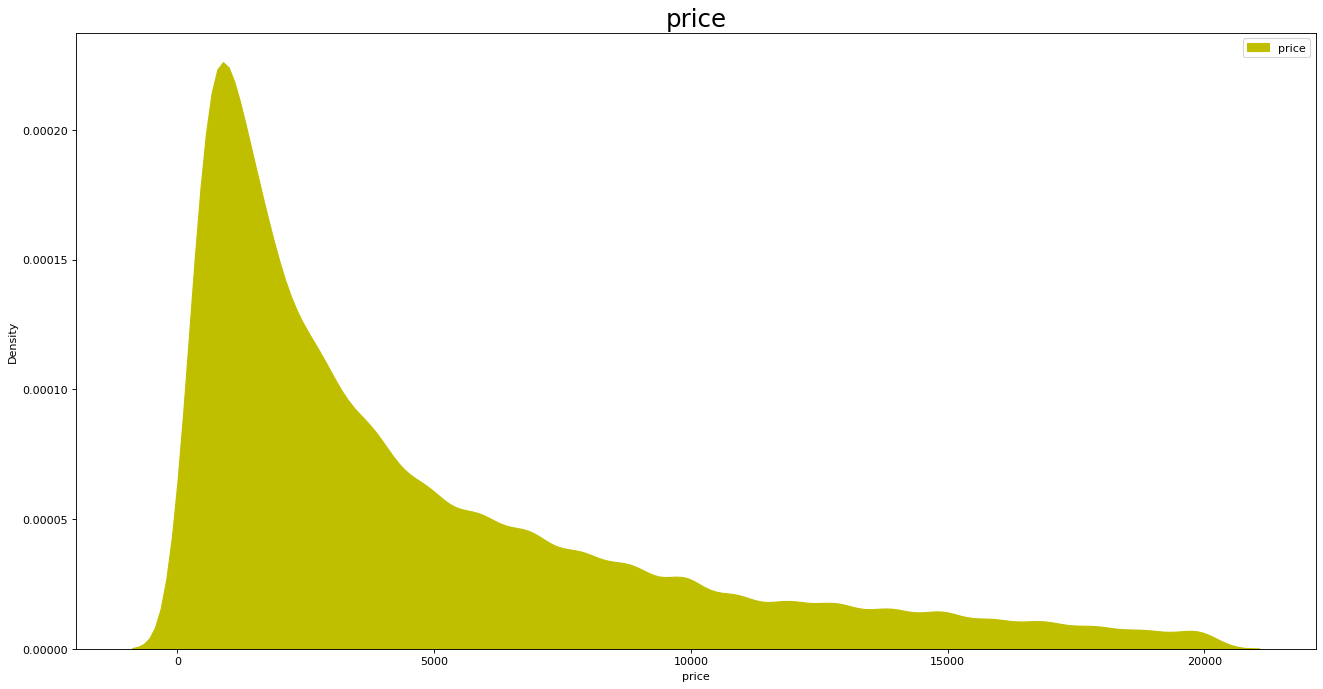

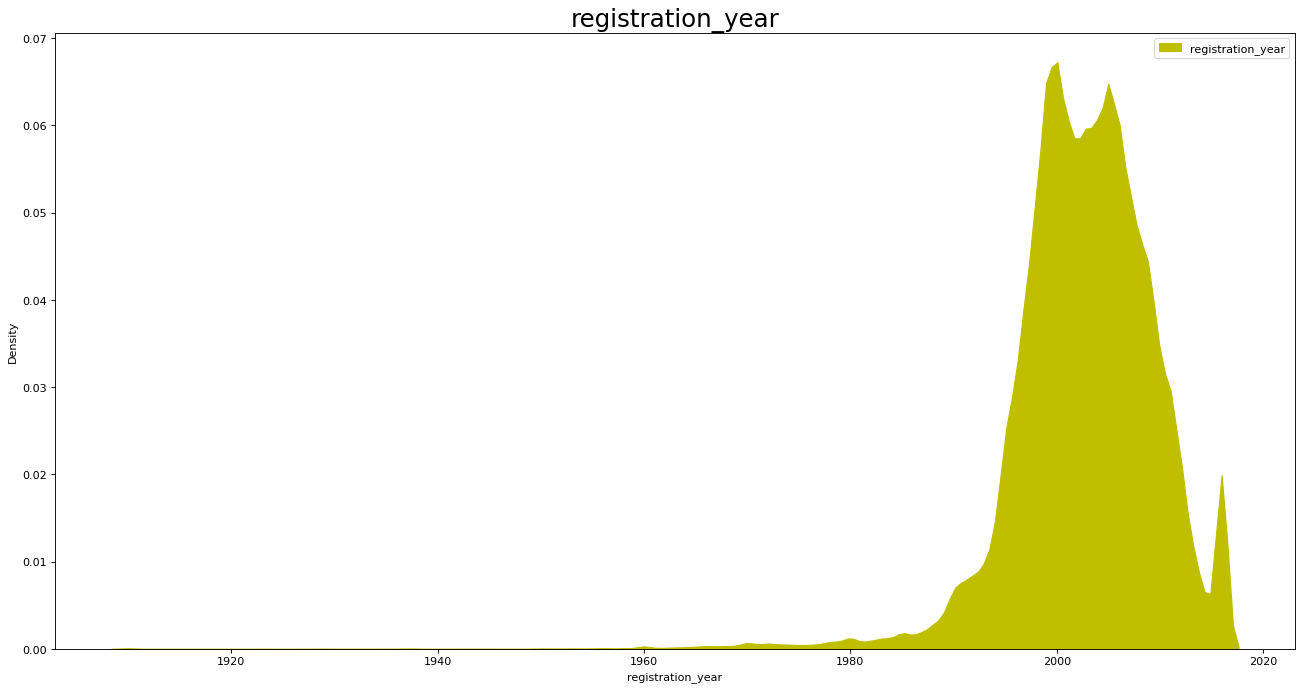

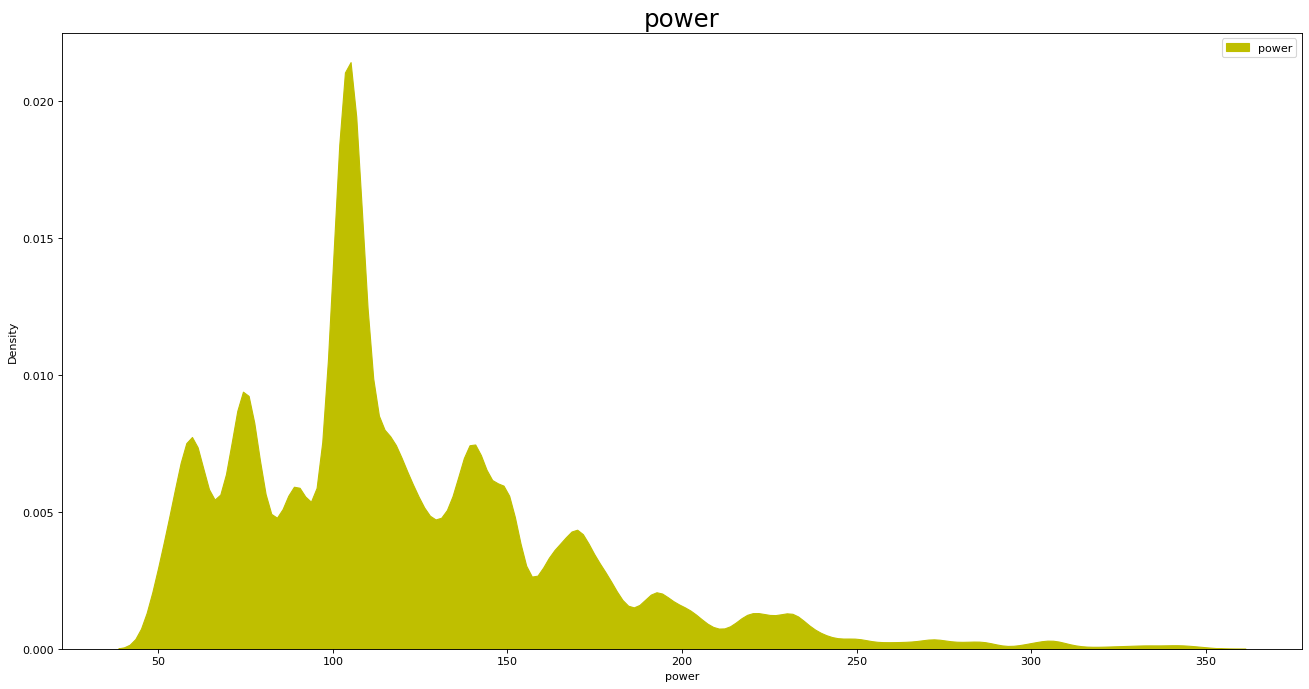

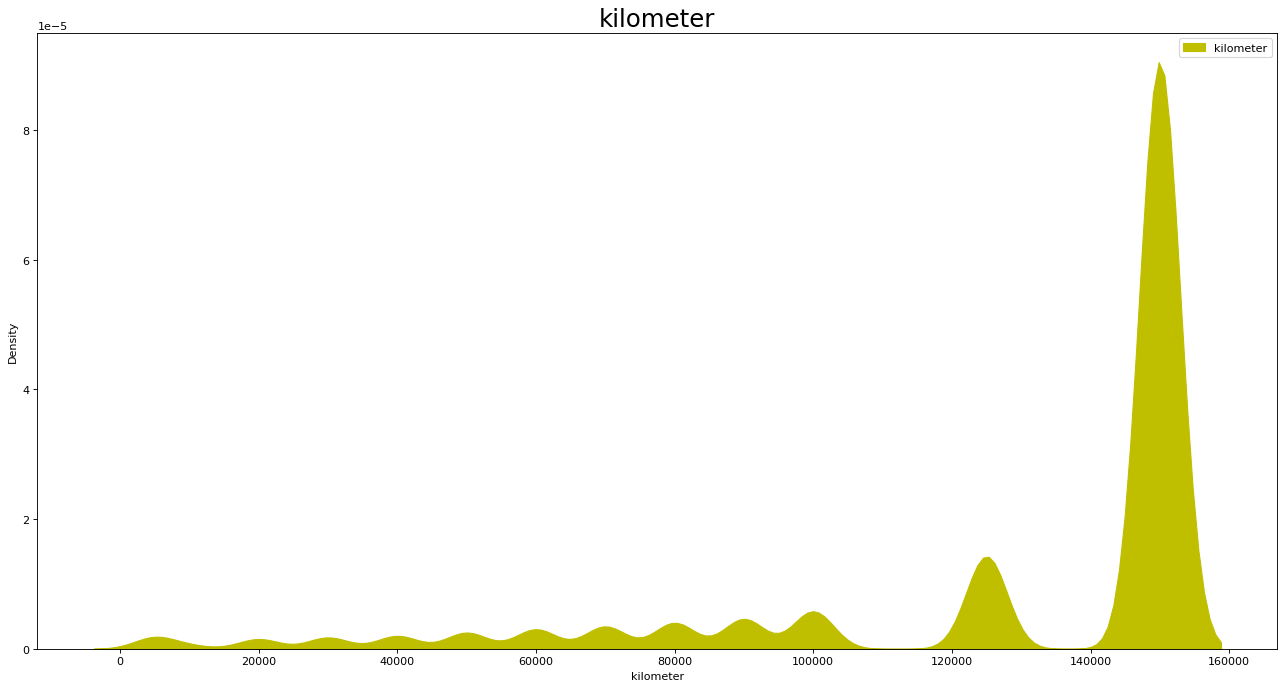

In [44]:
for i in dig_features:
    function_digital(data, i)

Вывод по этапу 1.
Скачали и изучили данные. Провели предобработку данных - обработали пропуски и аномалии в данных. Корреляция признаков либо слабая, либо отсутствует. Подготовили данные к обучению моделей. 

## Обучение моделей

### Регрессионные модели

Создадим пустой Датафрем для записи результатов

In [45]:
data_analys = pd.DataFrame(columns = ['LinearRegression', 'SGDRegressor', 
                          'CatBoostRegressor', 'LGBMRegressor'], 
                           index=['RMSE', 'RMSE с подбором параметров',
                                  'Время обучения модели', 'Время предсказания модели'])

In [46]:
data_analys

,LinearRegression,SGDRegressor,CatBoostRegressor,LGBMRegressor
RMSE,NaN,NaN,NaN,NaN
RMSE с подбором параметров,NaN,NaN,NaN,NaN
Время обучения модели,NaN,NaN,NaN,NaN
Время предсказания модели,NaN,NaN,NaN,NaN


In [47]:
data_ohe = data.copy()

```python
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
```

In [48]:
# Разделим выборки на обучающую и тестовую

y = data_ohe['price']
X = data_ohe.drop('price', axis=1)
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=state) 

print('Размер тренировочной выборки:', X_train_ohe.shape)
print('Размер тестовой выборки:', X_test_ohe.shape)


Размер тренировочной выборки: (242436, 10)
Размер тестовой выборки: (80812, 10)


In [49]:
X_train_ohe = pd.get_dummies(X_train_ohe, drop_first=True)

In [50]:
X_test_ohe = pd.get_dummies(X_test_ohe, drop_first=True)

In [51]:
common_columns = set(X_train_ohe.columns) & set(X_test_ohe.columns)

In [52]:
X_train_ohe = X_train_ohe[list(common_columns)]
X_test_ohe = X_test_ohe[list(common_columns)]

In [53]:
# Масштабируем признаки

numeric = ['registration_year', 'power', 'kilometer', 'registration_month']
scaler = StandardScaler()
scaler.fit(X_train_ohe[numeric])
X_train_ohe[numeric] = scaler.transform(X_train_ohe[numeric])
X_test_ohe[numeric] = scaler.transform(X_test_ohe[numeric])

Первой моделью будет линейная регрессия.
Обычный метод наименьших квадратов быстро обучается и возвращает простую модель, которая быстро дает прогноз. Поэтому именно его рекомендуется использовать в качестве первой попытки решить любую задачу регрессии.

In [54]:
# Модель линейной регрессии

model_lr = LinearRegression()

In [55]:
t0= time.time()

model_lr.fit(X_train_ohe, y_train_ohe)

time_lr_fit = time.time() - t0

data_analys.loc['Время обучения модели', 'LinearRegression'] = time.time() - t0

In [56]:
t0= time.time()

predictions = model_lr.predict(X_train_ohe)

data_analys.loc['Время предсказания модели', 'LinearRegression'] = time.time() - t0

In [57]:
data_analys.loc['RMSE', 'LinearRegression'] = np.sqrt(mean_squared_error(y_train_ohe, predictions))

Проведем кросс-валидацию модели

In [58]:
# Модель линейной регрессии с кросс-валидацией

model_lr_cv = LinearRegression()

In [59]:
%%time

mse_lr_cv = (cross_val_score(model_lr_cv, 
                          X_train_ohe,
                          y_train_ohe,
                          cv=5,
                             scoring='neg_mean_squared_error').mean())


CPU times: total: 34 s
Wall time: 18.4 s


In [60]:
data_analys.loc['RMSE с подбором параметров', 'LinearRegression'] = np.sqrt(abs(mse_lr_cv)) 

In [61]:
data_analys

,LinearRegression,SGDRegressor,CatBoostRegressor,LGBMRegressor
RMSE,2723.456033,NaN,NaN,NaN
RMSE с подбором параметров,2727.627491,NaN,NaN,NaN
Время обучения модели,4.851208,NaN,NaN,NaN
Время предсказания модели,0.435832,NaN,NaN,NaN


С применением перекрестной проверки получается более консервативная оценка (то есть с большей погрешностью). 
Оценка, полученная с помощью перекрестной проверки, точнее показывает, чего можно ожидать от обобщения модели на ранее не предъявлявшиеся данные. Целевой показатель метрики не достигнут.

Попробуем использовать другие библиотеки scikit-learn, например SGDRegressor.

Класс SGDRegressor реализует простую процедуру обучения стохастическим градиентным спуском, которая поддерживает различные функции потерь и штрафы для соответствия моделям линейной регрессии. SGDRegressor хорошо подходят для задач регрессии с большим количеством учебных образцов (> 10.000).

In [62]:
# Модель SGDRegressor
t0= time.time()

model_sgd = SGDRegressor() 
model_sgd.fit(X_train_ohe, y_train_ohe)
data_analys.loc['Время обучения модели', 'SGDRegressor'] = time.time() - t0

In [63]:
t0= time.time()

predictions = model_sgd.predict(X_train_ohe)
data_analys.loc['Время предсказания модели', 'SGDRegressor'] = time.time() - t0

In [64]:
data_analys.loc['RMSE', 'SGDRegressor'] = np.sqrt(mean_squared_error(y_train_ohe, predictions))

SGD требует ряда гиперпараметров, таких как параметр регуляризации и количество итераций. Подберем их.

In [65]:
model_sgd_grid = SGDRegressor() 

parameters_grid = {
    'alpha' : np.linspace(0.00001, 0.0001, 5),
#     'learning_rate': ['optimal', 'constant', 'invscaling'],
#     'eta0' : np.linspace(0.00001, 0.0001, 15),
    'max_iter' : np.arange(1000, 10001, 5000),
}


In [66]:
%%time

grid = GridSearchCV(model_sgd_grid, 
                       parameters_grid, 
                       scoring = 'neg_mean_squared_error', 
                       n_jobs=-1,
                       verbose=True,
                       cv = 3)
grid.fit(X_train_ohe, y_train_ohe)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 22.1 s
Wall time: 1min 55s


GridSearchCV(cv=3, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': array([1.00e-05, 3.25e-05, 5.50e-05, 7.75e-05, 1.00e-04]),
                         'max_iter': array([1000, 6000])},
             scoring='neg_mean_squared_error', verbose=True)

In [67]:
# Используем подобранные гиперпараметры

model_sgd_grid = SGDRegressor(**grid.best_params_) 
model_sgd_grid.fit(X_train_ohe, y_train_ohe)

SGDRegressor(alpha=1e-05)

In [68]:
predictions = model_sgd_grid.predict(X_train_ohe)

In [69]:
data_analys.loc['RMSE с подбором параметров', 'SGDRegressor'] = np.sqrt(mean_squared_error(y_train_ohe, predictions))

In [70]:
data_analys

,LinearRegression,SGDRegressor,CatBoostRegressor,LGBMRegressor
RMSE,2723.456033,2730.812425,NaN,NaN
RMSE с подбором параметров,2727.627491,2729.089598,NaN,NaN
Время обучения модели,4.851208,21.048007,NaN,NaN
Время предсказания модели,0.435832,0.320943,NaN,NaN


Регрессионные модели обучаются достаточно быстро, работают с приемлемой скоростью, но точность предсказаний не дотягивает до целевых показателей. Попробуем модели бустинга.

### Модель CatBoostRegressor

Преимущества данной модели:
1. CatBoost позволяет проводить обучение на нескольких GPU.
2. Библиотека позволяет получить отличные результаты с параметрами по умолчанию, что сокращает время, необходимое для настройки гиперпараметров.
3. Обеспечивает повышенную точность за счет уменьшения переобучения.
4. Возможность быстрого предсказания с применением модели CatBoost;
5. Обученные модели CatBoost можно экспортировать в Core ML для вывода на устройстве (iOS).
6. Умеет под капотом обрабатывать пропущенные значения.
7. Позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать.
Исходя из представленных разработчиками данных необходимости преобразовывать категориальные признаки в числовые нет. Используем первичные данные

Подготовим данные для работы модели

In [71]:
X = data.drop('price', axis=1)
y = data.price

In [72]:
# Разделим выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=state) 

print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (242436, 10)
Размер тестовой выборки: (80812, 10)


Создатели модели утверждают, что дефолтные параметры являются оптимальными для большинства задач. Проверим на нашем датасете

In [73]:
# Проверим модель на дефолтных параметрах

model_cbr = CatBoostRegressor(
   loss_function='RMSE'
)


In [74]:
t0= time.time()

model_cbr.fit(X_train, y_train, cat_features=cat_features, verbose=200)

data_analys.loc['Время обучения модели', 'CatBoostRegressor'] = time.time() - t0

Learning rate set to 0.097487
0:	learn: 4265.0835247	total: 231ms	remaining: 3m 50s
200:	learn: 1748.5822821	total: 16.3s	remaining: 1m 4s
400:	learn: 1675.9486663	total: 32.5s	remaining: 48.5s
600:	learn: 1638.5912958	total: 48.9s	remaining: 32.4s
800:	learn: 1613.1880736	total: 1m 5s	remaining: 16.3s
999:	learn: 1592.8293094	total: 1m 21s	remaining: 0us


In [75]:
t0= time.time()

predictions = model_cbr.predict(X_train)

data_analys.loc['Время предсказания модели', 'CatBoostRegressor'] = time.time() - t0

data_analys.loc['RMSE', 'CatBoostRegressor']= np.sqrt(mean_squared_error(y_train, predictions))

In [76]:
data_analys

,LinearRegression,SGDRegressor,CatBoostRegressor,LGBMRegressor
RMSE,2723.456033,2730.812425,1591.761819,NaN
RMSE с подбором параметров,2727.627491,2729.089598,NaN,NaN
Время обучения модели,4.851208,21.048007,83.056278,NaN
Время предсказания модели,0.435832,0.320943,0.614767,NaN


На дефолтных параметрах модель показывет очень хорошие результаты: как скорость обучения и работы, так и точность предсказаний.

Попробуем изменить гиперпараметры

In [77]:
%%time

model_cbr_tune = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)

parameters_cbr_tune = {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
#         'l2_leaf_reg': [1, 3]
              }
model_cbr_tune = GridSearchCV(model_cbr_tune, 
                        parameters_cbr_tune, 
                        cv = 2, 
                        n_jobs=-1,
                              scoring = 'neg_mean_squared_error').fit(X_train,
                                                                y_train, verbose=500)

0:	learn: 4241.5451225	total: 126ms	remaining: 2m 5s
500:	learn: 1560.8943933	total: 56s	remaining: 55.8s
999:	learn: 1480.9541771	total: 1m 51s	remaining: 0us
CPU times: total: 2min
Wall time: 5min 54s


In [78]:
predictions = model_cbr_tune.predict(X_train)

data_analys.loc['RMSE с подбором параметров', 'CatBoostRegressor']= np.sqrt(mean_squared_error(y_train, predictions))

In [79]:
data_analys

,LinearRegression,SGDRegressor,CatBoostRegressor,LGBMRegressor
RMSE,2723.456033,2730.812425,1591.761819,NaN
RMSE с подбором параметров,2727.627491,2729.089598,1494.546315,NaN
Время обучения модели,4.851208,21.048007,83.056278,NaN
Время предсказания модели,0.435832,0.320943,0.614767,NaN


Точность предсказаний высока, однако время обучения и время предсказаний выше, чем у линейных моделей.

### Модель LightGBM

In [80]:
# Проверим модель на дефолтных параметрах
t0= time.time()

model_lgb = LGBMRegressor()
model_lgb.fit(X_train_ohe, y_train_ohe)

data_analys.loc['Время обучения модели', 'LGBMRegressor'] = time.time() - t0

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 242436, number of used features: 290
[LightGBM] [Info] Start training from score 4689.649017


In [81]:
t0= time.time()

predictions = model_lgb.predict(X_train_ohe)

data_analys.loc['Время предсказания модели', 'LGBMRegressor'] = time.time() - t0

data_analys.loc['RMSE', 'LGBMRegressor']= np.sqrt(mean_squared_error(y_train_ohe, predictions))

Попробуем изменить гиперпараметры

In [82]:
parameters_grid = {'max_depth': [6, 8],
                   'learning_rate': [0.01, 0.1],
                  }

In [83]:
%%time

model_lgb_tuned = GridSearchCV(model_lgb, 
                               parameters_grid, 
                               scoring='neg_mean_squared_error',
                               cv=3).fit(X_train_ohe, y_train_ohe)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 161624, number of used features: 284
[LightGBM] [Info] Start training from score 4702.787822
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitl

In [84]:
%%time

predictions = model_lgb_tuned.predict(X_train_ohe)
data_analys.loc['RMSE с подбором параметров', 'LGBMRegressor']= np.sqrt(mean_squared_error(y_train_ohe, predictions))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 2.14 s
Wall time: 578 ms


## Анализ моделей

Проанализируем полученные экспериментальные данные

In [85]:
data_analys = data_analys.astype(float)
data_analys.T.style.highlight_min(color="yellow")

,RMSE,RMSE с подбором параметров,Время обучения модели,Время предсказания модели
LinearRegression,2723.456033,2727.627491,4.851208,0.435832
SGDRegressor,2730.812425,2729.089598,21.048007,0.320943
CatBoostRegressor,1591.761819,1494.546315,83.056278,0.614767
LGBMRegressor,1732.864456,1747.696861,1.284275,0.624604


По результатам проверки рекомендуем заказчику модель CatBoostRegressor с гиперпараметрами, установленными по дефолту. У этой модели оптимальное соотношение качества предсказаний и времени предсказаний. С учетом того факта, что обучение требуется не так часто, по моему мнению лучше ориентироваться на качество и скорость предсказаний. Однако в случае уточнения требований заказчика и смещения приоритетов на скорость обучения необходимо рассмотреть модель LGBMRegressor.

In [86]:
# Проверим выбранную модель на тестовых данных
t0= time.time()
predictions_test = model_cbr.predict(X_test)
# predictions_test = model_cbr_tune.predict(X_test)
print('RMSE выбранной модели на тестовых данных', np.sqrt(mean_squared_error(y_test, predictions_test)))
print('Время предсказания модели на тестовых данных', time.time() - t0, 'секунд')

RMSE выбранной модели на тестовых данных 1658.3635636975896
Время предсказания модели на тестовых данных 0.2057788372039795 секунд


In [87]:
# Проверим модель на адекватность
dummy_clf = DummyRegressor(strategy="mean")

dummy_clf.fit(X_train, y_train)

predictions_dummy = dummy_clf.predict(X_test)

print('RMSE Dummy модели на тестовых данных', np.sqrt(mean_squared_error(y_test, predictions_dummy)))

RMSE Dummy модели на тестовых данных 4542.975592657969


## Общий вывод по проекту.
Загрузили, изучили и подготовили данные к исследованию. \
Подготовили данные для обучения моделей с учетом требований моделей.\
Обучили разные модели: 'LinearRegression', 'SGDRegressor', 'CatBoostRegressor', 'LGBMRegressor'.\
Для каждой модели попробовали разные гиперпараметры.\
Проанализировали время обучения, время предсказания и качество моделей,\
Занесли данные в таблицу, визуализировали результаты.\
Выбрали лучшую модель, проверили её качество на тестовой выборке.\
Проверили модель на адекватность.